# Pruning

In [1]:
import sys
sys.path.append("..")

In [2]:
from asyncio import MultiLoopChildWatcher
from doctest import OutputChecker

from turtle import hideturtle
import warnings

from models import GeneralModel
from models.statistics.Metrics import Metrics
from utils.config_utils import *
from utils.model_utils import *
from utils.system_utils import *

import matplotlib.pyplot as plt
from models.networks.ConvertMLP import ConvertMLP2,ConvertMLP3

from verify_utils.verify_utils import verify_single_image

warnings.filterwarnings("ignore")

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [3]:
torch.__version__

'1.11.0+cu113'

In [4]:
# define arguments manually
arguments = {}
# device
arguments['device'] = "cuda"

# define arguments for model
#arguments.model = "ResNet18" # ResNet not supported for structured
arguments['model'] = "MLP2"
arguments['hidden_dim'] = 64
#arguments.input_dim = None # for ResNet
#arguments.input_dim = (1,1,1) # for LeNet5
arguments['input_dim'] = (28,28) # for MNIST
arguments['output_dim'] = 10
arguments['disable_masking'] = 1 # 0 for disable mask, 1 for mask (unstructured)
arguments['track_weights'] = 0
arguments['enable_rewinding'] = 0
arguments['growing_rate'] = 0.0000
arguments['outer_layer_pruning'] = 0
# arguments.prune_criterion = "SNIPit"  # unstructured

arguments['prune_criterion'] = "SNAPit" # or SNAPit ... # structured
arguments['l0'] = 0
arguments['l0_reg'] = 1.0
arguments['l1_reg'] = 0
arguments['lp_reg'] = 0
arguments['l2_reg'] = 5e-5
arguments['hoyer_reg'] = 0.001
arguments['N'] = 6000 # different for different dataset
arguments['beta_ema'] = 0.999


# define arguments for criterion
arguments['pruning_limit'] = 0.75
arguments['snip_steps'] = 6

# not pre-trained model
arguments['checkpoint_name'] = None
arguments['checkpoint_model'] = None

# dataset
arguments['data_set'] = "MNIST"
arguments['batch_size'] = 512
arguments['mean'] = (0.1307,)
arguments['std'] = (0.3081,)
arguments['tuning'] = 0
arguments['preload_all_data'] = 0
arguments['random_shuffle_labels'] = 0

# loss
arguments['loss'] = "CrossEntropy"

# optimizer
arguments['optimizer'] = "ADAM"
arguments['learning_rate'] = 2e-3

# training
arguments['save_freq'] = 2
arguments['eval'] = 0
arguments['train_scheme'] = "DefaultTrainer"
arguments['seed'] = 1234
arguments['epochs'] = 6

arguments['grad_noise'] = 0
arguments['grad_clip'] =10
arguments['eval_freq'] = 1000
arguments['max_training_minutes']= 6120
arguments['plot_weights_freq'] = 50
arguments['prune_delay'] = 0
arguments['prune_freq'] = 1
arguments['rewind_to'] = 6

arguments['skip_first_plot'] = 0
arguments['disable_histograms'] = 0
arguments['disable_saliency'] = 0
arguments['disable_confusion'] = 0
arguments['disable_weightplot'] = 0
arguments['disable_netplot'] = 0
arguments['disable_activations'] = 0

arguments['pruning_rate'] = 0
# during training
arguments['pruning_freq'] = 1

In [5]:
metrics = Metrics()
out = metrics.log_line
print = out

ensure_current_directory()
global out 
out = metrics.log_line
out(f"starting at {get_date_stamp()}")

metrics._batch_size = arguments['batch_size']
metrics._eval_freq = arguments['eval_freq']

starting at 2022-05-18_17.38.00


In [6]:
device = configure_device(arguments)

In [7]:
# get model
model: GeneralModel = find_right_model(
        NETWORKS_DIR,arguments['model'],
        device=device,
        hidden_dim = arguments['hidden_dim'],
        input_dim = arguments['input_dim'],
        output_dim = arguments['output_dim'],
        is_maskable=arguments['disable_masking'],
        is_tracking_weights=arguments['track_weights'],
        is_rewindable=arguments['enable_rewinding'],
        is_growable=arguments['growing_rate'] > 0,
        outer_layer_pruning=arguments['outer_layer_pruning'],
        maintain_outer_mask_anyway=(
                                       not arguments['outer_layer_pruning']) and (
                                           "Structured" in arguments['prune_criterion']),
        l0=arguments['l0'],
        l0_reg=arguments['l0_reg'],
        N=arguments['N'],
        beta_ema=arguments['beta_ema'],
        l2_reg=arguments['l2_reg']
    ).to(device)

In [8]:
for key,param in model.named_parameters():
    print(param.size())

torch.Size([64, 784])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [9]:
# get criterion
criterion = find_right_model(
        CRITERION_DIR,arguments['prune_criterion'],
        model=model,
        limit=arguments['pruning_limit'],
        start=0.5,
        steps=arguments['snip_steps'],
        device=arguments['device']
    )   

In [10]:
# load data
train_loader, test_loader = find_right_model(
        DATASETS, arguments['data_set'],
        arguments=arguments,
        mean=arguments['mean'],
        std=arguments['std']
    )

Using mean (0.1307,)


In [11]:
# get loss function
loss = find_right_model(
        LOSS_DIR, arguments['loss'],
        device=device,
        l1_reg=arguments['l1_reg'],
        lp_reg=arguments['lp_reg'],
        l0_reg=arguments['l0_reg'],
        hoyer_reg=arguments['hoyer_reg']
    )

In [12]:
# get optimizer
optimizer = find_right_model(
        OPTIMS, arguments['optimizer'],
        params=model.parameters(),
        lr=arguments['learning_rate'],
        weight_decay=arguments['l2_reg'] if not arguments['l0'] else 0
    )


In [13]:
if not arguments['eval']:
    # build trainer
    run_name = f"_model={arguments['model']}_dataset={arguments['data_set']}_prune-criterion={arguments['prune_criterion']}" + \
               f"_pruning-limit={arguments['pruning_limit']}_train-scheme={arguments['train_scheme']}_seed={arguments['seed']}"
    trainer = find_right_model(
            TRAINERS_DIR, arguments['train_scheme'],
            model=model,
            loss=loss,
            optimizer=optimizer,
            device=device,
            arguments=arguments,
            train_loader=train_loader,
            test_loader=test_loader,
            metrics=metrics,
            criterion=criterion,
            run_name = run_name
        )

Made datestamp: 2022-05-18_17.38.04_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.75_train-scheme=DefaultTrainer_seed=1234


In [14]:
trainer.train()

Started training
Saved results/2022-05-18_17.38.04_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.75_train-scheme=DefaultTrainer_seed=1234/output/scores
pruning 25088 percentage 0.5 length_nonzero 50176
pruning 320 percentage 0.5 length_nonzero 640
  (layers): Sequential(
    (0): ContainerLinear(in_features=784, out_features=32.0, bias=True)
    (2): ContainerLinear(in_features=32.0, out_features=10, bias=True)
final percentage after snap: 0.5
Saved results/2022-05-18_17.38.04_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.75_train-scheme=DefaultTrainer_seed=1234/output/scores
pruning 7056 percentage 0.28125 length_nonzero 25088
pruning 90 percentage 0.28125 length_nonzero 320
  (layers): Sequential(
    (0): ContainerLinear(in_features=784, out_features=23.0, bias=True)
    (2): ContainerLinear(in_features=23.0, out_features=10, bias=True)
final percentage after snap: 0.28125
Saved results/2022-05-18_17.38.04_model=MLP2_dataset=MNIST_prune-criterion=

<Figure size 432x288 with 0 Axes>

In [15]:
for key,param in model.named_parameters():
    print(param.size())

torch.Size([15, 784])
torch.Size([15])
torch.Size([10, 15])
torch.Size([10])


# Load saved models and saved metrics

In [16]:
import pickle

In [17]:
result_path = "gitignored/results"
ex_paths = os.listdir(result_path)

models_path = os.path.join(result_path,ex_paths[0],"models")
model_path=os.listdir(models_path)
#print(model_path)
# read metric
metric_name = list(filter(lambda x: "finished" in x and "Metrics" in x ,model_path))[0]
metric_path = os.path.join(models_path,metric_name)

with open(metric_path, 'rb') as pickle_file:
    metric = pickle.load(pickle_file)
metric["_data"]["acc/test"]

# read model
model_name = list(filter(lambda x: "finished" in x and "mod" in x ,model_path))[0]
model_path = os.path.join(models_path,model_name)

with open(model_path, 'rb') as pickle_file:
    model = pickle.load(pickle_file)

model.to(device)


MLP2(
  (layers): Sequential(
    (0): ContainerLinear(in_features=784, out_features=15.0, bias=True)
    (1): ReLU()
    (2): ContainerLinear(in_features=15.0, out_features=10, bias=True)
  )
)

In [25]:
# use DATAMANAGER is better
# already has RESULTS_DIR, MODELS_DIR
checkpoint_name = "2022-05-05_10.07.09_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.5_train-scheme=DefaultTrainer_seed=1234"
checkpoint_model_state = "MLP2_finished"
checkpoint_model = "MLP2_mod_finished"
state_path = os.path.join(RESULTS_DIR,checkpoint_name,MODELS_DIR,checkpoint_model_state)
model_path = os.path.join(RESULTS_DIR,checkpoint_name,MODELS_DIR,checkpoint_model)
state= DATA_MANAGER.load_python_obj(state_path)
model=DATA_MANAGER.load_python_obj(model_path)
model

results/2022-05-05_10.07.09_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.5_train-scheme=DefaultTrainer_seed=1234/models/MLP2_finished not loaded because file is missing
results/2022-05-05_10.07.09_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.5_train-scheme=DefaultTrainer_seed=1234/models/MLP2_mod_finished not loaded because file is missing


In [19]:
# save model
#save_path='/nfs/homedirs/wangxun/robustness/SparseNetwork-Verification/gitignored/results/MLP/2022-05-05_14.51.27_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.75_train-scheme=DefaultTrainer_seed=1234/models/MLP2_finished'
save_path = '/nfs/homedirs/wangxun/robustness/SparseNetwork-Verification/gitignored/results/MLP/try/try.pickle'
DATA_MANAGER.save_python_obj(model,save_path)

[Errno 2] No such file or directory: '/nfs/homedirs/wangxun/robustness/SparseNetwork-Verification/gitignored/results/MLP/try/try.pickle.pickle'
Failed saving /nfs/homedirs/wangxun/robustness/SparseNetwork-Verification/gitignored/results/MLP/try/try.pickle, continue anyway


# Quantization

In [16]:
# change to cpu and eval mode
model.to("cpu").eval()

# get the model parameters
state = model.state_dict()
# convet the model to a quantizable model
q_model= ConvertMLP2(model)
# load previous parameter
q_model.load_state_dict(state)
# set quantization config
q_model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
# fuse_model
q_model.fuse

<bound method ConvertMLP2.fuse of ConvertMLP2(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=10, bias=True)
  )
  (quant): QuantStub()
  (dequant): DeQuantStub()
)>

In [17]:
# use calibrate date to calibrate model
model_prepared = torch.quantization.prepare(q_model)
cali_data,label=next(iter(train_loader))
model_prepared(cali_data)

tensor([[ -4.2574,   0.0325,   4.5682,  ...,   0.5100,   1.8329,  -1.0362],
        [ -1.2456,  -4.7140,  -3.3629,  ...,  -7.0423,   4.4800,   2.9256],
        [  9.0897, -12.7721,  -0.9435,  ...,  -1.4990,   3.4533,   2.1567],
        ...,
        [ -8.3921,   0.4202,  -7.7041,  ...,   0.1281,   3.2470,   4.2118],
        [ -5.7385,  -2.1109,  -6.3270,  ...,   7.6626,  -2.4278,   6.2139],
        [ -1.2479,  -7.8603,  -2.0022,  ...,  -1.6067,  -4.2694,   1.1689]],
       grad_fn=<AddmmBackward0>)

In [18]:
# convert to int8
model_int8 = torch.quantization.convert(model_prepared)

In [19]:
model_int8

ConvertMLP2(
  (layers): Sequential(
    (0): QuantizedLinear(in_features=784, out_features=15, scale=0.535760760307312, zero_point=45, qscheme=torch.per_channel_affine)
    (1): ReLU()
    (2): QuantizedLinear(in_features=15, out_features=10, scale=0.3231096565723419, zero_point=67, qscheme=torch.per_channel_affine)
  )
  (quant): Quantize(scale=tensor([0.0254]), zero_point=tensor([16]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

In [20]:
# compare the model size
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

In [21]:
size_model_fp32 = print_size_of_model(model,label="fp32model")
size_model_int8 = print_size_of_model(model_int8,label="quantized")


model:  fp32model  	 Size (KB): 49.247
model:  quantized  	 Size (KB): 16.699


# manually implement inference of quantized model

In [124]:
# see https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/quantized/cudnn/Conv.cpp#L304 
# for detaile| numeric implementation
# get model

images,labels=next(iter(test_loader))
#torch.max(torch.clamp((torch.round(images/x_1_scale+16)),min=0,max=127)-model_int8.quant(images).int_repr())

In [125]:
# get the fixed parameters in the model
W_scales=[]

W_int=[]
B=[]
out_scales=[]
out_zps=[]

in_scale= model_int8.quant.scale
in_zp= torch.tensor(model_int8.quant.zero_point,dtype=torch.int8)

for layer in model_int8.layers:
    if hasattr(layer,"scale"):
        w,b = layer._weight_bias()
        W_scales.append(w.q_per_channel_scales().numpy())
        W_int.append(w.int_repr())
        B.append(b.detach())
        out_scales.append(layer.scale)
        out_zps.append(layer.zero_point)

In [126]:
def round_int8(x):
    #return torch.clamp(torch.round(x),min=0,max=127)
    return torch.clamp(torch.round(x),min=0)
def relu_int8(x,zero_point):
    return (x<=zero_point)*zero_point+(x>zero_point)*x

In [127]:
images,labels=next(iter(test_loader))
# convert the input to int
images = images.squeeze().view(-1,28*28)

x_int=round_int8(images/in_scale+in_zp)
n_layers = len(W_int)
# calculate output for every layer 
_output=[]

for i in range(n_layers):
    # formula to calculate output
    out=(x_int-in_zp).int()@W_int[i].T.int()*W_scales[i]*in_scale/out_scales[i]+B[i]/out_scales[i]+out_zps[i]
    out=round_int8(out)
    _output.append(out)
    # layers with relu activation
    if i<n_layers-1:
    # calculate ReLU activation
        out = relu_int8(out,out_zps[i])
        in_zp = out_zps[i]
        in_scale = out_scales[i]
        x_int=out
        _output.append(out)


In [128]:
# test if match the model output
print(torch.sum(torch.argmax(out,axis=1)!=torch.argmax(model_int8(images),axis=1)))
#print(_output[0][10])
#print(_output[1][10])
#print(_output[2][10])

tensor(0)


In [129]:
# get a test image 
images,labels=next(iter(test_loader))
img = images[10]
label = labels[10]
print("label is ",label.item())

label is  0


In [131]:
# target output for every layer
#input_1=model_int8.quant(img).view(-1,28*28)
#input_1 = torch.round(img/0.0254+16).view(-1,28*28)
input_1 = model_int8.quant(images).view(-1,28*28)
out_1=model_int8.layers[0](input_1)
out_2=model_int8.layers[1](out_1)
out_3=model_int8.layers[2](out_2)
out_4 = model_int8.dequant(out_3)
#print(out_1)
#print(out_2)
#print(out_3)
#print(out_4)
#print(out_1.int_repr())
#print(out_2.int_repr())
#print(out_3.int_repr())
#print(torch.max(input_1.int_repr()))
#print(torch.max(out_1.int_repr()))
#print(torch.max(out_2.int_repr()))
#print(torch.max(out_3.int_repr()))
print(torch.sum(out_1.int_repr()!=_output[0]))
print(torch.sum(out_2.int_repr()!=_output[1]))
print(torch.sum(out_3.int_repr()!=_output[2]))

tensor(0)
tensor(0)
tensor(0)


# how to verify a quantized model ?

In [229]:
import cvxpy as cp
from tqdm.auto import tqdm

In [230]:
# get the fixed parameters of the model
W_scales=[]
#W_zps=0 so remove here
#W_zps=[]
W_int=[]
B=[]
out_scales=[]
out_zps=[]

in_scale= model_int8.quant.scale.numpy()
in_zp= torch.tensor(model_int8.quant.zero_point,dtype=torch.int8).numpy()

for layer in model_int8.layers:
    if hasattr(layer,"scale"):
        w,b = layer._weight_bias()
        W_scales.append(w.q_per_channel_scales().numpy())
        W_int.append(w.int_repr().numpy())
        B.append(b.detach().numpy().reshape(-1))
        out_scales.append(layer.scale)
        out_zps.append(layer.zero_point)

In [272]:
# get a test img
images,labels=next(iter(test_loader))
img_test = images[0]
num_classes=model_int8.output_dim
c = torch.argmax(model_int8(img_test)).item()
print("label is ",c)
other_classes = set(range(num_classes))
other_classes.remove(c)

# perturbation budget
eps=0.3

label is  7


In [273]:
W1=W_int[0]
b1=B[0]
W2=W_int[1]
b2=B[1]
img_test=img_test.numpy().reshape(-1)

In [274]:

# lower and upper bounds before first quantization 
u0=img_test+eps
l0=img_test-eps
# step 1 quantize x
# _x = x/in_scale + in_zp
# _x_int = round(_x)
# x_int = clamp(_x_int,min=0)
x = cp.Variable(shape=(img_test.shape))
_x = cp.Variable(shape=(img_test.shape))
_x_int = cp.Variable(shape=(img_test.shape),integer=True)
x_int = cp.Variable(shape=(img_test.shape),integer=True)
# boolean variable for clamp constraint
a0 = cp.Variable(shape=(img_test.shape), boolean=True)


# output of first layer
# y1 = W1@(x_int-x_zp)*W_scales[0]*in_scale/out_scales[0]+b1/out_scales[0]+out_zps[0]
# _y1_int = round(y1)
# y1_int = clamp(_y1_int,min=0)
y1 = cp.Variable(shape=(W1.shape[0]))
_y1_int = cp.Variable(shape=(W1.shape[0]),integer=True)
y1_int = cp.Variable(shape=(W1.shape[0]),integer=True)
# boolean variable for clamp constraints
a1_1 = cp.Variable(shape=(W1.shape[0]), boolean=True)

# output of a ReLU function
y1_out = cp.Variable(shape=(W1.shape[0]),integer=True)
#  boolean variable for relu constraints
a1_2 = cp.Variable(shape=(W1.shape[0]), boolean=True)

# output of second layer
# y2 = W2@(y1_out-out_zps[0])*W_scales[1]*out_scales[0]/out_scales[1]+b2/out_scales[1]+out_zps[1]
# _y2_int = round(y2)
# y2_int = clamp(_y2_int,min=0)
y2 = cp.Variable(shape=(W2.shape[0]))
_y2_int = cp.Variable(shape=(W2.shape[0]),integer=True)
y2_int = cp.Variable(shape=(W2.shape[0]),integer=True)
#  boolean variable for clamp constraints
a2 = cp.Variable(shape=(W2.shape[0]), boolean=True) 

In [279]:
# get lower and upper bounds after scaling
in_scale_p = np.maximum(0,1/in_scale)
in_scale_m = np.maximum(-1/in_scale,0)

u0_1 = in_scale_p*u0-in_scale_m*l0+in_zp
l0_1 = in_scale_p*l0-in_scale_m*u0+in_zp

# get lower and upper bounds after round
_u0_int=np.round(u0_1)
_l0_int=np.round(l0_1)

# get lower and upper bounds after clamp
u0_int=np.clip(_u0_int,a_min=0,a_max=None)
l0_int=np.clip(_l0_int,a_min=0,a_max=None)

# get lower and upper bounds after first layer calculation
W1_p = np.maximum(0,W1)
W1_m = np.maximum(-W1,0)

u1 = (W1_p @ (u0_int-in_zp) - W1_m @ (l0_int-in_zp))*W_scales[0]*in_scale/out_scales[0] + b1/out_scales[0]+out_zps[0]
l1 = (W1_p @ (l0_int-in_zp) - W1_m @ (u0_int-in_zp))*W_scales[0]*in_scale/out_scales[0] + b1/out_scales[0]+out_zps[0]

# get lower and upper bounds after round
_u1_int=np.round(u1)
_l1_int=np.round(l1)

# get lower and upper bounds after clamp
u1_int=np.clip(_u1_int,a_min=0,a_max=None)
l1_int=np.clip(_l1_int,a_min=0,a_max=None)

# get lower and upper bounds after relu  do I need this ?

# get lower and upper bounds after second layer calculation
# the output scale and zero point of first layer are the input scale and zero point of second layer
W2_p = np.maximum(0,W2)
W2_m = np.maximum(-W2,0)

u2 = (W2_p @ (u1_int-out_zps[0]) - W2_m @ (l1_int-out_zps[0]))*W_scales[1]*out_scales[0]/out_scales[1] + b2/out_scales[1]+out_zps[1]
l2 = (W2_p @ (l1_int-out_zps[0]) - W2_m @ (u1_int-out_zps[0]))*W_scales[1]*out_scales[0]/out_scales[1] + b2/out_scales[1]+out_zps[1]

# get lower and upper bounds after round
_u2_int=np.round(u1)
_l2_int=np.round(l1)




In [276]:
# define constraints
constraints=[]
constraints += [_x==x/in_scale+in_zp]
# round operation
constraints += [cp.atoms.norm_inf(_x-_x_int) <= 0.5]
# clamp operation one similar to relu 
# constrains of clip (x>0)
constraints += [x_int[i] <= _x_int[i] - _l0_int[i] * (1 - a0[i]) for i in range(x_int.shape[0])]
constraints += [x_int[i] >= _x_int[i] for i in range(x_int.shape[0])]
constraints += [x_int[i] <= _u0_int[i]*a0[i] for i in range(x_int.shape[0])]
constraints += [x_int[i] >= 0 for i in range(x_int.shape[0])]
"""
# not used again
# constraints of clip (x<127)
constraints += [x_int[i] >= _x_int[i] - (_u0_int[i]-127) * (1 - a0_2[i]) for i in range(x_int.shape[0])]
constraints += [x_int[i] <= _x_int[i] for i in range(x_int.shape[0])]
constraints += [x_int[i] >= 127+(_l0_int[i]-127)*a0_2[i] for i in range(x_int.shape[0])]
constraints += [x_int[i] <= 127 for i in range(x_int.shape[0])]
"""
# constraints of first layer 
constraints += [y1 == W1@(x_int-in_zp)*W_scales[0]*in_scale/out_scales[0]+b1/out_scales[0]+out_zps[0]]

# constrains of round operation
constraints += [cp.atoms.norm_inf(y1-_y1_int) <= 0.5]

# constrains of clip
constraints += [y1_int[i] <= _y1_int[i] - _l1_int[i] * (1 - a1_1[i]) for i in range(y1_int.shape[0])]
constraints += [y1_int[i] >= _y1_int[i] for i in range(y1_int.shape[0])]
constraints += [y1_int[i] <= _u1_int[i]*a1_1[i] for i in range(y1_int.shape[0])]
constraints += [y1_int[i] >= 0 for i in range(y1_int.shape[0])]
"""
# not used again
constraints += [y1_int[i] >= _y1_int[i] - (_u1_int[i]-127) * (1 - a1_2[i]) for i in range(y1_int.shape[0])]
constraints += [y1_int[i] <= _y1_int[i] for i in range(y1_int.shape[0])]
constraints += [y1_int[i] >= 127+(_l1_int[i]-127)*a1_2[i] for i in range(y1_int.shape[0])]
constraints += [y1_int[i] <= 127 for i in range(y1_int.shape[0])]
"""

# constraints for relu of first layer (zero_point = out_zps[0])

constraints += [y1_out[i] <= y1_int[i] - (l1_int[i]-out_zps[0]) * (1 - a1_2[i]) for i in range(y1_int.shape[0])]
constraints += [y1_out[i] >= y1_int[i] for i in range(y1_int.shape[0])]
constraints += [y1_out[i] <= out_zps[0]+(u1_int[i]-out_zps[0])*a1_2[i] for i in range(y1_int.shape[0])]
constraints += [y1_out[i] >= out_zps[0] for i in range(y1_int.shape[0])]

# constraints of second layer
constraints += [y2 == W2@(y1_out-out_zps[0])*W_scales[1]*out_scales[0]/out_scales[1]+b2/out_scales[1]+out_zps[1]]

# constraints of round operation
constraints += [cp.atoms.norm_inf(y2-_y2_int) <= 0.5]

# constraints of clip
constraints += [y2_int[i] <= _y2_int[i] - _l2_int[i] * (1 - a2[i]) for i in range(y2_int.shape[0])]
constraints += [y2_int[i] >= _y2_int[i] for i in range(y2_int.shape[0])]
constraints += [y2_int[i] <= _u2_int[i]*a2[i] for i in range(y2_int.shape[0])]
constraints += [y2_int[i] >= 0 for i in range(y2_int.shape[0])]

# constrainst of input pertubation
constraints += [cp.atoms.norm_inf(img_test-x) <= eps]

In [277]:
for other in tqdm(other_classes):
    problem=cp.Problem(objective=cp.Minimize(y2_int[c]-y2_int[other]),constraints=constraints)
    opt = problem.solve('MOSEK')
    if opt < 0:
        print('found solution')
        break

  0%|          | 0/9 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'reshape'

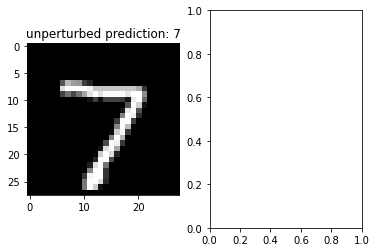

In [278]:

plt.subplot(121)
plt.imshow(img_test.reshape(28,28), cmap='gray')
plt.title(f"unperturbed prediction: {c}")
plt.subplot(122)
plt.imshow(x.value.reshape(28, 28), cmap='gray')
plt.title(f"perturbed prediction: {y2_int.value.argmax()}")
plt.show()

# Directly load model and verify

In [51]:
img.reshape(-1,1).shape
img.

torch.Size([784, 1])

# Verify

## test single image verify

In [271]:
img,label=next(iter(test_loader))
img_test = img[0].squeeze().to(device)
model.to(device)
img,label,indicator=verify_single_image(model=model,image=img_test,eps=0.3)
if indicator==0:
    print("verified!")


In [59]:
img_test.reshape(-1).shape

torch.Size([784])

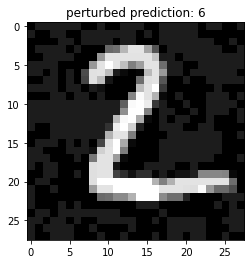

In [54]:
plt.imshow(img.value.reshape(28, 28), cmap='gray')
plt.title(f"perturbed prediction: {label.value.argmax()}")
plt.show()

## multi-processing to get robustness accuracy

In [24]:
from verify_utils.verify_utils import verify_batch_images
import time

## compare time without multi-processing

In [26]:
# a seririalized implementation
start = time.time()
img_number=0
verified_number=0
imgs,labels=next(iter(test_loader))
eps = 0.01
model.to(device)
img_number += len(imgs)
for img in imgs:
    img = img.squeeze().to(device)
    _,_,indicator = verify_single_image(model=model,image=img,eps=eps)
    if indicator==0:
        verified_number+=1
finish=time.time()
print(f"accuracy:{verified_number/img_number}")
print(f"time elapsed {finish-start}s")
    


found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
accuracy:0.966796875
time elapsed 962.2611734867096s


In [30]:
print(f"total_num:{img_number},verified_num:{verified_number}")

total_num:512,verified_num:495


In [27]:
from multiprocessing import Process, Value,Lock
import time
from verify_utils.verify_utils import verify_batch_images

In [33]:
# multi processing
start = time.time()
# step1 get a batch images
imgs,labels=next(iter(test_loader))
model.to(device)
# start from a GPU model and tensor imgs
# step2 get the labels for a batch imgs
labels=model(imgs.to(device)).argmax(axis=1).cpu().numpy()
# step 3 split imgs and labels for each process
num_process =10
processes=[]
num_per_process=int(len(imgs)/num_process)
# convert model to cpu
model.to("cpu")
# define processes
lock =Lock()
total_num = Value('i',0)
verified_num = Value('i',0)
eps=0.01
for i in range(num_process):
    if i!=num_process-1:
        process_imgs=imgs[num_per_process*i:num_per_process*(i+1)].squeeze()
        process_labels = labels[num_per_process*i:num_per_process*(i+1)]
    else:
        process_imgs=imgs[num_per_process*i:].squeeze()
        process_labels = labels[num_per_process*i:]
    p=Process(target=verify_batch_images,args=(model,process_imgs,process_labels,eps,total_num,verified_num,lock))
    processes.append(p)
    
# start
for p in processes:
    p.start()
    
# join
for p in processes:
    p.join()
finish = time.time()

print(f"total_num:{total_num.value},verified_num:{verified_num.value}")
print(f"accuracy:{verified_num.value/total_num.value}")
print(f"time elapsed {finish-start}s")

found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
total_num:512,verified_num:495
accuracy:0.966796875
time elapsed 547.378613948822s


In [ ]:
# 2  cpu 526.1203780174255s
# 4  cpu 534.806479215622s
# 10 cpu 548.1252098083496s 547.378613948822s